In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
import json
import re
import pandas as pd
import numpy as np
import requests
from pyspark.sql.functions import lower
from pyspark.sql.functions import col


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Domain modeling")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.port", "6066")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/07 19:16:28 WARN Utils: Your hostname, DESKTOP-VD1EQUL resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/10/07 19:16:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/07 19:16:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
domain_cleaned_pyspark = spark.read.parquet("../data/curated/domain_cleaned_pyspark", header=True)

finished_df_full = spark.read.csv("../data/curated/finished_df_full.csv", header=True)
finished_df = spark.read.csv("../data/curated/finished_df.csv", header=True)

partial_joined_full = spark.read.csv("../data/curated/partial_joined_full.csv", header=True)
partial_joined = spark.read.csv("../data/curated/partial_joined.csv", header=True)

partial_joined_part_2_full = spark.read.csv("../data/curated/partial_joined_part_2_full.csv", header=True)
partial_joined_part_2 = spark.read.csv("../data/curated/partial_joined_part_2.csv", header=True)

In [3]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

**domain_cleaned_pyspark**

In [29]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [30]:
pattern = r'.* VIC \d{4}$'

# Filter rows that match the pattern
domain_clean = domain_cleaned_pyspark.filter(F.col('suburb').rlike(pattern))

In [31]:
domain_clean = domain_clean.withColumn('location', F.split(F.col('suburb'), ' VIC ')[0])
domain_clean = domain_clean.drop("suburb")
domain_clean = domain_clean.withColumnRenamed("location", "suburb")

In [32]:
domain_clean.limit(1)

url,name,latitude,longitude,bedrooms,bathrooms,type,car_parks,cost_text,postcode,rent_pw,school_name,school_walking,school_driving,hospital_name,hospital_walking,hospital_driving,doctors_name,doctors_walking,doctors_driving,bank_name,bank_walking,bank_driving,restaurant_name,restaurant_walking,restaurant_driving,PTV_name,PTV_walking,PTV_driving,rate_type,cost_per_week,suburb
https://www.domai...,8/94 Kerferd Stre...,-37.73580320000001,144.9000261,2,1,Apartment / Unit ...,1,$475 per week,3041,475,Parkville College,32.84,32.84,Dorset Rehabilita...,13.37,20.32,Professional Foot...,7.72,8.2,Commonwealth Bank,2.93,13.41,Jan Cheong Restau...,6.28,12.65,Essendon Railway ...,24.31,39.23,weekly,475.0,Essendon North


In [33]:
domain_clean = domain_clean.drop("url",
                                 "name",
                                 "cost_text",
                                 "school_name",
                                 "hospital_name",
                                 "doctors_name",
                                 "bank_name",
                                 "restaurant_name",
                                 "PTV_name",
                                 "rent_pw",
                                 "latitude", 
                                 "longitude")

In [34]:
domain_clean.limit(1)

bedrooms,bathrooms,type,car_parks,postcode,school_walking,school_driving,hospital_walking,hospital_driving,doctors_walking,doctors_driving,bank_walking,bank_driving,restaurant_walking,restaurant_driving,PTV_walking,PTV_driving,rate_type,cost_per_week,suburb
2,1,Apartment / Unit ...,1,3041,32.84,32.84,13.37,20.32,7.72,8.2,2.93,13.41,6.28,12.65,24.31,39.23,weekly,475.0,Essendon North


In [35]:
domain_clean.describe()

summary,bedrooms,bathrooms,type,car_parks,postcode,school_walking,school_driving,hospital_walking,hospital_driving,doctors_walking,doctors_driving,bank_walking,bank_driving,restaurant_walking,restaurant_driving,PTV_walking,PTV_driving,rate_type,cost_per_week,suburb
count,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039,9039
mean,2.684035844673083,1.573625401039938,NULL,1.376479699081757,3219.8607146808276,23.99190618431241,40.98838035180893,19.767883615444163,22.862823321163876,11.553330014382134,18.51511782276802,9.865818121473616,18.674159752185002,10.717206549397066,17.214622192720444,8.78948113729398,38.32545303684034,NULL,649.4961418084305,NULL
stddev,1.08407401074103,0.6308398157683572,NULL,1.0097905097827737,262.1360190869276,27.66403639842813,46.26216529167019,11.216014938726113,11.625044428808366,7.558803071177277,16.381799012494394,8.228591041302554,22.60713743488822,10.276700631807277,10.453548010002716,7.924862135161191,22.232705842158108,NULL,321.8777613039166,NULL
min,0,0,Acreage / Semi-Rural,0,3000,5.29,9.3,1.41,1.71,0.1,0.1,0.02,0.46,0.1,0.13,0.07,0.11,monthly,220.0,Abbotsford
max,9,12,Villa,19,3996,196.35,196.35,55.44,55.44,49.87,156.37,82.8,225.12,270.75,161.75,70.31,99.61,yearly,2672.0,Yinnar


In [36]:
domain_clean_pd = domain_clean.toPandas()

In [37]:
domain_clean_pd.dtypes

bedrooms                int64
bathrooms               int64
type                   object
car_parks               int64
postcode               object
school_walking        float64
school_driving        float64
hospital_walking      float64
hospital_driving      float64
doctors_walking       float64
doctors_driving       float64
bank_walking          float64
bank_driving          float64
restaurant_walking    float64
restaurant_driving    float64
PTV_walking           float64
PTV_driving           float64
rate_type              object
cost_per_week         float64
suburb                 object
dtype: object

In [38]:
domain_clean_pd['postcode'] = domain_clean_pd['postcode'].astype(int)

In [ ]:
domain_clean_pd = domain_clean_pd.dropna()

In [39]:
domain_numerical = domain_clean_pd.drop(columns = ["type", "suburb", 
                                                   "postcode",
                                                   "bedrooms", "bathrooms",
                                                   "car_parks", "rate_type",
                                                   "cost_per_week"])

domain_categorical = domain_clean_pd[["type", "suburb", "rate_type"]]

domain_important = domain_clean_pd[["bedrooms", "bathrooms", "car_parks", "postcode"]]

domain_one_hot = pd.get_dummies(domain_categorical, 
                                columns=['type', 'suburb', "rate_type"], 
                                drop_first=True)

scaler = StandardScaler()
domain_scaled = scaler.fit_transform(domain_numerical)
domain_scaled_df = pd.DataFrame(domain_scaled, columns=domain_numerical.columns)
domain_scaled_important = scaler.fit_transform(domain_important)
domain_scaled_important = pd.DataFrame(domain_scaled_important, columns=domain_important.columns)


# X_0 = pd.concat([domain_important.reset_index(drop=True), domain_numerical, domain_one_hot.reset_index(drop=True)], axis = 1)
# X_1 = pd.concat([domain_important.reset_index(drop=True), domain_scaled_df, domain_one_hot.reset_index(drop=True)], axis = 1)
# X_2 = pd.concat([domain_scaled_important, domain_scaled_df, domain_one_hot.reset_index(drop=True)], axis = 1)

X = pd.concat([domain_important.reset_index(drop=True), domain_numerical, domain_one_hot.reset_index(drop=True)], axis = 1)
y = domain_clean_pd['cost_per_week']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Gradient Boosting RMSE: 234.68570722288194
Gradient Boosting MAE: 127.14334201838841
Gradient Boosting r^2: 0.33804060660542146

Top 10 Most Significant Features:
              Feature  Importance
1           bathrooms    0.214537
0            bedrooms    0.128826
15        PTV_driving    0.119218
3            postcode    0.100077
4      school_walking    0.046056
2           car_parks    0.036603
106  suburb_ Brighton    0.033117
14        PTV_walking    0.032647
235    suburb_ Echuca    0.029709
7    hospital_driving    0.024313


/tmp/ipykernel_27883/2622895179.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, gb_pred], labels=['Actual', 'Gradient Boosting Predictions'])


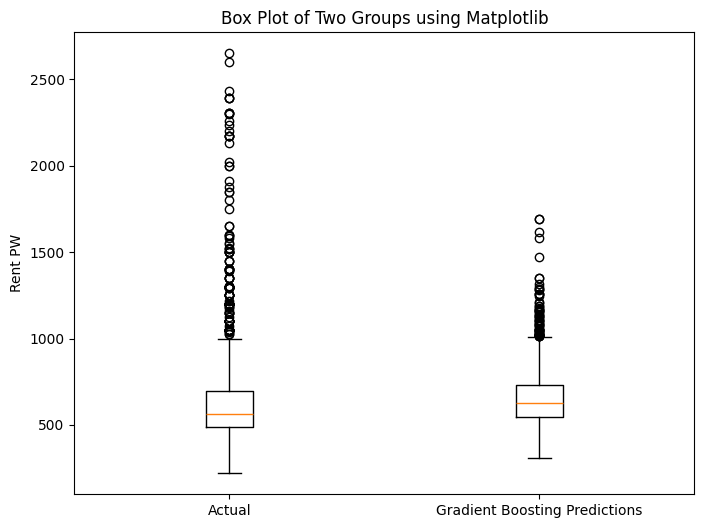

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

gb_mae = mean_absolute_error(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_r2 = r2_score(y_test, gb_pred)

print("Gradient Boosting RMSE:", gb_rmse)
print("Gradient Boosting MAE:", gb_mae)
print("Gradient Boosting r^2:", gb_r2)

feature_importances = gb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("")

# Top 5 most significant features
print("Top 10 Most Significant Features:")
print(importance_df.head(10))

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, gb_pred], labels=['Actual', 'Gradient Boosting Predictions'])

# Add title and labels
plt.title('Box Plot of Two Groups using Matplotlib')
plt.xlabel('')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

Random Forest Regression RMSE: 251.03346563359548
Random Forest Regression MAE: 118.10206910663308
Random Forest Regression r^2: 0.24260695868362347
Top 10 Most Significant Features:
               Feature  Importance
1            bathrooms    0.104420
0             bedrooms    0.089013
15         PTV_driving    0.078307
3             postcode    0.067091
2            car_parks    0.064078
12  restaurant_walking    0.062964
13  restaurant_driving    0.057084
4       school_walking    0.038963
11        bank_driving    0.033881
10        bank_walking    0.032469


/tmp/ipykernel_27883/3942784696.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, rf_predictions], labels=['Actual', 'RFR Predictions'])


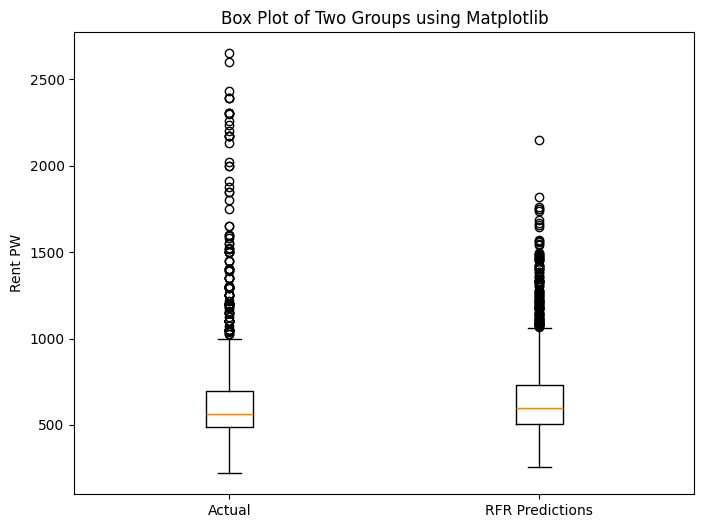

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Fit Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Regression RMSE:", rf_rmse)
print("Random Forest Regression MAE:", rf_mae)
print("Random Forest Regression r^2:", rf_r2)

# Feature importance for Random Forest
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Top 5 most significant features
print("Top 10 Most Significant Features:")
print(importance_df.head(10))

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, rf_predictions], labels=['Actual', 'RFR Predictions'])

# Add title and labels
plt.title('Box Plot of Two Groups using Matplotlib')
plt.xlabel('')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

Lasso Regression RMSE: 240.79657811911343
Lasso Regression MAE: 132.31292933051535
Lasso Regression r^2: 0.30311889535564485


/tmp/ipykernel_27883/4002892836.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, lasso_pred], labels=['Actual', 'Lasso Predictions'])


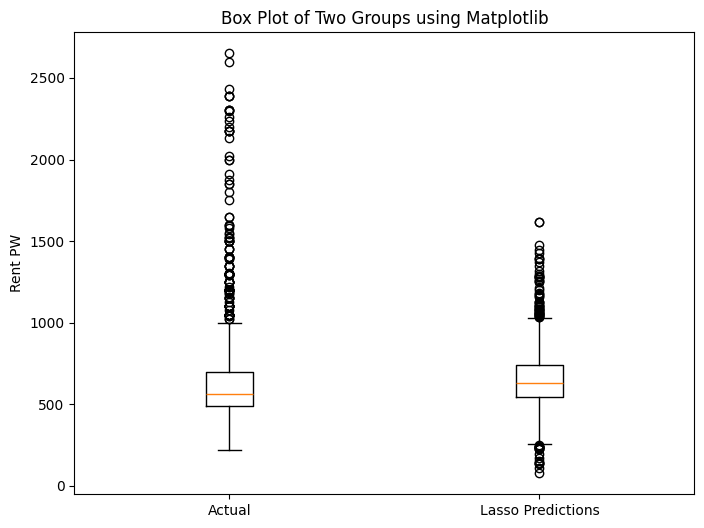

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Step 3: Fit the Lasso regression model
lasso = Lasso(alpha=0.1)  # You can adjust the alpha (regularization strength) as needed
lasso.fit(X_train, y_train)

# Step 4: Predict on the test data and evaluate the model
lasso_pred = lasso.predict(X_test)

# Step 5: Calculate the Mean Squared Error (MSE)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print("Lasso Regression RMSE:", lasso_rmse)
print("Lasso Regression MAE:", lasso_mae)
print("Lasso Regression r^2:", lasso_r2)

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, lasso_pred], labels=['Actual', 'Lasso Predictions'])

# Add title and labels
plt.title('Box Plot of Two Groups using Matplotlib')
plt.xlabel('')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

In [44]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

**partial_joined**

In [ ]:
break

**Finished_df**

In [4]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [5]:
finished_df_full.describe()

24/10/07 19:16:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/10/07 19:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1039.4 KiB
24/10/07 19:17:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/10/07 19:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1039.4 KiB
24/10/07 19:17:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


summary,suburb,url,name,latitude,longitude,bedrooms,bathrooms,type,car_parks,cost_text,postcode,rent_pw,school_name,school_walking,school_driving,hospital_name,hospital_walking,hospital_driving,doctors_name,doctors_walking,doctors_driving,bank_name,bank_walking,bank_driving,restaurant_name,restaurant_walking,restaurant_driving,PTV_name,PTV_walking,PTV_driving,rate_type,cost_per_week,a20_assault_and_related_offences,a50_robbery,"a70_stalking,_harassment_and_threatening_behaviour",a80_dangerous_and_negligent_acts_endangering_people,other_crimes_against_the_person,b10_arson,b20_property_damage,b30_burglary/break_and_enter,b40_theft,b50_deception,c10_drug_dealing_and_trafficking,c20_cultivate_or_manufacture_drugs,c30_drug_use_and_possession,d10_weapons_and_explosives_offences,d20_disorderly_and_offensive_conduct,d30_public_nuisance_offences,e10_justice_procedures,e20_breaches_of_orders,f20_transport_regulation_offences,f90_miscellaneous_offences,c90_other_drug_offences,f30_other_government_regulatory_offences,d40_public_security_offences,f10_regulatory_driving_offences,b60_bribery,total_crimes,best_school_number_vce_subjects,best_school_satisfactory_complete_vce_percent,best_school_median_study_score,best_school_study_score_over_40_percent,best_school_percentage_applying_to_victorian_uni,avg_school_number_vce_subjects,avg_school_satisfactory_complete_vce_percent,avg_school_median_study_score,avg_school_study_score_over_40_percent,avg_school_percentage_applying_to_victorian_uni,zoned_school_number_vce_subjects,zoned_school_satisfactory_complete_vce_percent,zoned_school_median_study_score,zoned_school_study_score_over_40_percent,zoned_school_percentage_applying_to_victorian_uni,crow_distance_to_cbd,distance_to_cbd,duration_to_cbd,total_area,developed_area,built_percentage,urban_percentage,disturbed_percentage,water_percentage,developed_percentage,nature_percentage,mean_economic: top 5% suburb,mean_economic: top 1% suburb,mean_economic: gini coefficient,mean_economic: trimmed mean quarterly,mean_economic: variable interest rate,mean_economic: gdp quarterly,mean_economic: gdp per capita quarterly,mean_population: 0-4,mean_population: 5-9,mean_population: 10-14,mean_population: 15-19,mean_population: 20-24,mean_population: 25-29,mean_population: 30-34,mean_population: 35-39,mean_population: 40-44,mean_population: 45-49,mean_population: 50-54,mean_population: 55-59,mean_population: 60-64,mean_population: 65-69,mean_population: 70-74,mean_population: 75-79,mean_population: 80-84,mean_population: 85 and over,mean_population: total persons,mean_population: growth,mean_birth: brazil,mean_birth: wales,mean_birth: papua new guinea,mean_birth: australia,mean_birth: malaysia,mean_birth: country of birth not stated,mean_birth: indonesia,mean_birth: egypt,mean_birth: afghanistan age,mean_birth: thailand,mean_birth: ireland,mean_birth: hong kong sar of china,mean_birth: nepal,mean_birth: north macedonia,mean_birth: england,mean_birth: chile,mean_birth: fiji,mean_birth: taiwan,mean_birth: japan,mean_birth: malta,mean_birth: scotland,mean_birth: china excludes sars and taiwan,mean_birth: poland,mean_birth: singapore,mean_birth: south africa,mean_birth: greece,mean_birth: pakistan,mean_birth: iraq,mean_birth: mauritius,mean_birth: samoa,mean_birth: sri lanka,mean_birth: india,mean_birth: philippines,mean_birth: vietnam,mean_birth: new zealand,mean_birth: iran,mean_birth: lebanon,mean_birth: france,mean_birth: total,mean_birth: netherlands,mean_birth: myanmar,mean_birth: united states of america,mean_birth: bosnia and herzegovina,mean_birth: zimbabwe,mean_birth: bangladesh,mean_birth: turkey,mean_birth: canada,mean_birth: korea republic of south,mean_birth: cambodia,mean_birth: born elsewhere,mean_birth: italy,mean_birth: croatia,mean_birth: germany,mean_studying: primary other,mean_studying: tertiary FT 14-25,mean_studying: tertiary FT 25+,mean_studying: primary total,mean_studying: tertiary PT 14-25,mean_studying: tertiary PT 25+,mean_studying: tafe

In [6]:
finished_df_full.limit(1)

suburb,url,name,latitude,longitude,bedrooms,bathrooms,type,car_parks,cost_text,postcode,rent_pw,school_name,school_walking,school_driving,hospital_name,hospital_walking,hospital_driving,doctors_name,doctors_walking,doctors_driving,bank_name,bank_walking,bank_driving,restaurant_name,restaurant_walking,restaurant_driving,PTV_name,PTV_walking,PTV_driving,rate_type,cost_per_week,a20_assault_and_related_offences,a50_robbery,"a70_stalking,_harassment_and_threatening_behaviour",a80_dangerous_and_negligent_acts_endangering_people,other_crimes_against_the_person,b10_arson,b20_property_damage,b30_burglary/break_and_enter,b40_theft,b50_deception,c10_drug_dealing_and_trafficking,c20_cultivate_or_manufacture_drugs,c30_drug_use_and_possession,d10_weapons_and_explosives_offences,d20_disorderly_and_offensive_conduct,d30_public_nuisance_offences,e10_justice_procedures,e20_breaches_of_orders,f20_transport_regulation_offences,f90_miscellaneous_offences,c90_other_drug_offences,f30_other_government_regulatory_offences,d40_public_security_offences,f10_regulatory_driving_offences,b60_bribery,total_crimes,best_school_number_vce_subjects,best_school_satisfactory_complete_vce_percent,best_school_median_study_score,best_school_study_score_over_40_percent,best_school_percentage_applying_to_victorian_uni,avg_school_number_vce_subjects,avg_school_satisfactory_complete_vce_percent,avg_school_median_study_score,avg_school_study_score_over_40_percent,avg_school_percentage_applying_to_victorian_uni,zoned_school_number_vce_subjects,zoned_school_satisfactory_complete_vce_percent,zoned_school_median_study_score,zoned_school_study_score_over_40_percent,zoned_school_percentage_applying_to_victorian_uni,crow_distance_to_cbd,distance_to_cbd,duration_to_cbd,total_area,developed_area,built_percentage,urban_percentage,disturbed_percentage,water_percentage,developed_percentage,nature_percentage,mean_economic: top 5% suburb,mean_economic: top 1% suburb,mean_economic: gini coefficient,mean_economic: trimmed mean quarterly,mean_economic: variable interest rate,mean_economic: gdp quarterly,mean_economic: gdp per capita quarterly,mean_population: 0-4,mean_population: 5-9,mean_population: 10-14,mean_population: 15-19,mean_population: 20-24,mean_population: 25-29,mean_population: 30-34,mean_population: 35-39,mean_population: 40-44,mean_population: 45-49,mean_population: 50-54,mean_population: 55-59,mean_population: 60-64,mean_population: 65-69,mean_population: 70-74,mean_population: 75-79,mean_population: 80-84,mean_population: 85 and over,mean_population: total persons,mean_population: growth,mean_birth: brazil,mean_birth: wales,mean_birth: papua new guinea,mean_birth: australia,mean_birth: malaysia,mean_birth: country of birth not stated,mean_birth: indonesia,mean_birth: egypt,mean_birth: afghanistan age,mean_birth: thailand,mean_birth: ireland,mean_birth: hong kong sar of china,mean_birth: nepal,mean_birth: north macedonia,mean_birth: england,mean_birth: chile,mean_birth: fiji,mean_birth: taiwan,mean_birth: japan,mean_birth: malta,mean_birth: scotland,mean_birth: china excludes sars and taiwan,mean_birth: poland,mean_birth: singapore,mean_birth: south africa,mean_birth: greece,mean_birth: pakistan,mean_birth: iraq,mean_birth: mauritius,mean_birth: samoa,mean_birth: sri lanka,mean_birth: india,mean_birth: philippines,mean_birth: vietnam,mean_birth: new zealand,mean_birth: iran,mean_birth: lebanon,mean_birth: france,mean_birth: total,mean_birth: netherlands,mean_birth: myanmar,mean_birth: united states of america,mean_birth: bosnia and herzegovina,mean_birth: zimbabwe,mean_birth: bangladesh,mean_birth: turkey,mean_birth: canada,mean_birth: korea republic of south,mean_birth: cambodia,mean_birth: born elsewhere,mean_birth: italy,mean_birth: croatia,mean_birth: germany,mean_studying: primary other,mean_studying: tertiary FT 14-25,mean_studying: tertiary FT 25+,mean_studying: primary total,mean_studying: tertiary PT 14-25,mean_studying: tertiary PT 25+,mean_studying: tafe total,m

In [7]:
finished_df_full = finished_df_full.drop("url",
                                         "name",
                                         "cost_text",
                                         "school_name",
                                         "hospital_name",
                                         "doctors_name",
                                         "bank_name",
                                         "restaurant_name",
                                         "PTV_name",
                                         "rent_pw",
                                         "latitude", 
                                         "longitude")

In [8]:
finished_df_full = finished_df_full.toPandas()

In [9]:
finished_df_full['postcode'] = finished_df_full['postcode'].astype(int)
finished_df_full['bedrooms'] = finished_df_full['bedrooms'].astype(int)
finished_df_full['bathrooms'] = finished_df_full['bathrooms'].astype(int)
finished_df_full['car_parks'] = finished_df_full['car_parks'].astype(int)

In [10]:
finished_df_full.head(1)

,suburb,bedrooms,bathrooms,type,car_parks,postcode,school_walking,school_driving,hospital_walking,hospital_driving,...,ages: 75-84,birth: lebanon,birth: bosnia and herzegovina,birth: ireland,birth: cambodia,relationships: lone parents,birth: australia,birth: hong kong sar of china,population: growth,birth: brazil
0,Alfredton,4,2,House,2,3350,20.91,20.91,40.58,40.58,...,3172,6,8,96,0,3462,53354,44,4.468375880369013,38


In [11]:
finished_df_full.shape

(3936, 277)

In [12]:
finished_df_full = finished_df_full.dropna()

In [13]:
finished_df_full.shape

(3936, 277)

In [14]:
finished_numerical = finished_df_full.drop(columns = ["type", "suburb", 
                                                   "postcode",
                                                   "bedrooms", "bathrooms",
                                                   "car_parks", "rate_type",
                                                   "cost_per_week"])

finished_categorical = finished_df_full[["type", "suburb", "rate_type"]]

finished_important = finished_df_full[["bedrooms", "bathrooms", "car_parks", "postcode"]]

finished_one_hot = pd.get_dummies(finished_categorical, 
                                  columns=['type', 'suburb', "rate_type"], 
                                  drop_first=True)

scaler = StandardScaler()
finished_scaled = scaler.fit_transform(finished_numerical)
finished_scaled_df = pd.DataFrame(finished_scaled, columns=finished_numerical.columns)
finished_scaled_important = scaler.fit_transform(finished_important)
finished_scaled_important = pd.DataFrame(finished_scaled_important, columns=finished_important.columns)

X = pd.concat([finished_important.reset_index(drop=True), finished_scaled_df, finished_one_hot.reset_index(drop=True)], axis = 1)
y = finished_df_full['cost_per_week']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
y_test.shape

(788,)

In [17]:
X_test.shape

(788, 450)

/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+07, tolerance: 3.839e+04
  model = cd_fast.enet_coordinate_descent(
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+06, tolerance: 3.100e+04
  model = cd_fast.enet_coordinate_descent(
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

-----------------------------------------------------------------
Lasso Regression RMSE: 292.000463479719
Lasso Regression MAE: 155.67632241244513
Lasso Regression R^2: 0.29845967448486077
-----------------------------------------------------------------


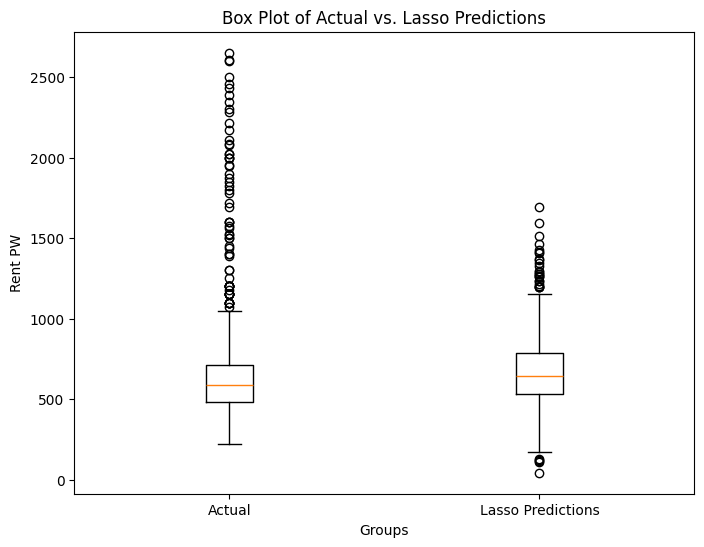

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Step 2: Initialize the Lasso regression model
lasso = Lasso(alpha=0.1)  # You can adjust the alpha (regularization strength) as needed

# Step 3: Fit the Lasso regression model
lasso.fit(X_train, y_train)

# Step 4: Predict on the test data
lasso_pred = lasso.predict(X_test)

# Define scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(lasso, X_train, y_train, scoring=scoring, cv=5)

# Step 5: Calculate the Mean Squared Error (MSE) and other metrics
lasso_rmse = np.sqrt(cv_results['test_neg_mean_squared_error']).mean()
lasso_mae = cv_results['test_neg_mean_absolute_error'].mean()
lasso_r2 = cv_results['test_r2'].mean()

# Print results
print("-----------------------------------------------------------------")
print("Lasso Regression RMSE:", lasso_rmse)
print("Lasso Regression MAE:", lasso_mae)
print("Lasso Regression R^2:", lasso_r2)
print("-----------------------------------------------------------------")

# Convert y_test and lasso_pred to float arrays
y_test = np.array(y_test).astype(float)
lasso_pred = np.array(lasso_pred).astype(float)

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, lasso_pred], labels=['Actual', 'Lasso Predictions'])

# Add title and labels
plt.title('Box Plot of Actual vs. Lasso Predictions')
plt.xlabel('Groups')
plt.ylabel('Rent PW')

# Show the plot
plt.show()


-----------------------------------------------------------------
Gradient Boosting RMSE: 273.47333492858655
Gradient Boosting MAE: 133.0668590575047
Gradient Boosting r^2: 0.38462936128836017
-----------------------------------------------------------------

Top 10 Most Significant Features:
                                      Feature  Importance
0                                    bedrooms    0.225783
1                                   bathrooms    0.178024
176                   economic: median income    0.070883
55   zoned_school_study_score_over_40_percent    0.053877
2                                   car_parks    0.046199
12                         restaurant_walking    0.027576
177           economic: median age of earners    0.026989
13                         restaurant_driving    0.025471
70            mean_economic: gini coefficient    0.024540
58                            distance_to_cbd    0.024192



/tmp/ipykernel_21408/2004749146.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, gb_pred], labels=['Actual', 'Gradient Boosting Predictions'])


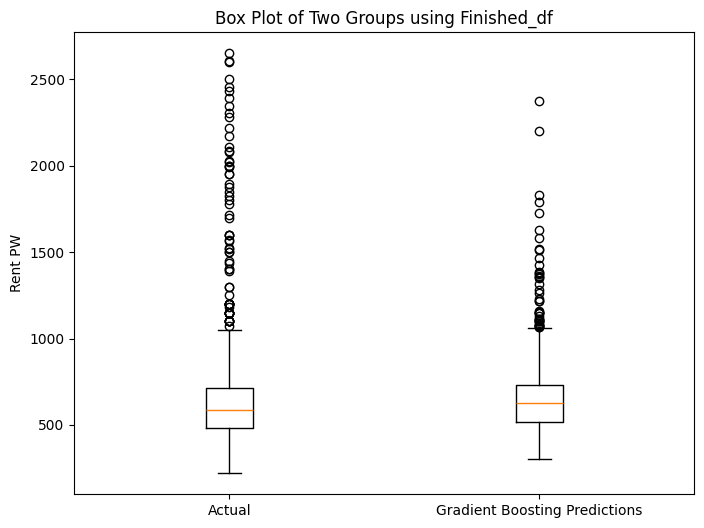

In [19]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Define scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(gb_model, X_train, y_train, scoring=scoring, cv=5)

# Step 5: Calculate the Mean Squared Error (MSE) and other metrics
gb_rmse = np.sqrt(cv_results['test_neg_mean_squared_error']).mean()
gb_mae = cv_results['test_neg_mean_absolute_error'].mean()
gb_r2 = cv_results['test_r2'].mean()

print("-----------------------------------------------------------------")
print("Gradient Boosting RMSE:", gb_rmse)
print("Gradient Boosting MAE:", gb_mae)
print("Gradient Boosting r^2:", gb_r2)
print("-----------------------------------------------------------------")

feature_importances = gb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("")
y_test = np.array(y_test).astype(float)
gb_pred = np.array(gb_pred).astype(float)

# Top 5 most significant features
print("Top 10 Most Significant Features:")
print(importance_df.head(10))
print("")

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, gb_pred], labels=['Actual', 'Gradient Boosting Predictions'])

# Add title and labels
plt.title('Box Plot of Two Groups using Finished_df')
plt.xlabel('')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

-----------------------------------------------------------------
Random Forest Regression RMSE: 273.47333492858655
Random Forest Regression MAE: 133.0668590575047
Random Forest Regression r^2: 0.38462936128836017
-----------------------------------------------------------------

Top 10 Most Significant Features:
                     Feature  Importance
0                   bedrooms    0.127906
1                  bathrooms    0.124388
12        restaurant_walking    0.063303
2                  car_parks    0.055008
13        restaurant_driving    0.050422
176  economic: median income    0.040035
10              bank_walking    0.026751
11              bank_driving    0.020765
9            doctors_driving    0.020067
59           duration_to_cbd    0.019633



/tmp/ipykernel_21408/2072455980.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, rf_predictions], labels=['Actual', 'RFR Predictions'])


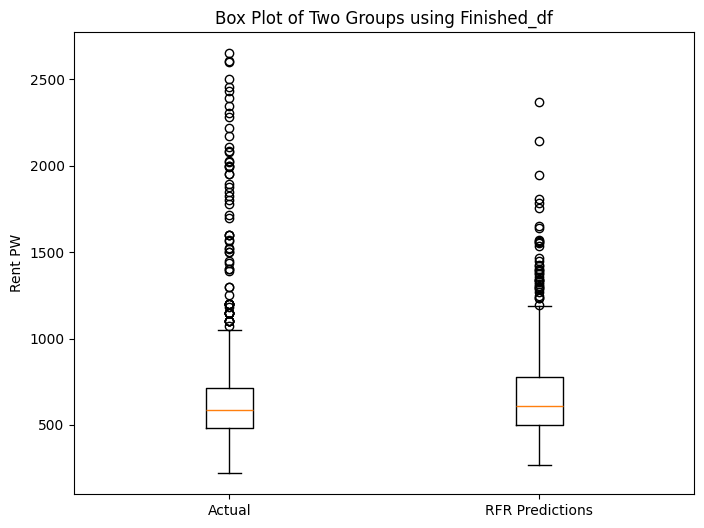

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Fit Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Define scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(gb_model, X_train, y_train, scoring=scoring, cv=5)

# Step 5: Calculate the Mean Squared Error (MSE) and other metrics
rf_rmse = np.sqrt(cv_results['test_neg_mean_squared_error']).mean()
rf_mae = cv_results['test_neg_mean_absolute_error'].mean()
rf_r2 = cv_results['test_r2'].mean()

# Predict on test data
rf_predictions = rf_model.predict(X_test)
print("-----------------------------------------------------------------")
print("Random Forest Regression RMSE:", rf_rmse)
print("Random Forest Regression MAE:", rf_mae)
print("Random Forest Regression r^2:", rf_r2)
print("-----------------------------------------------------------------")

# Feature importance for Random Forest
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("")
y_test = np.array(y_test).astype(float)
rf_predictions = np.array(rf_predictions).astype(float)

# Top 5 most significant features
print("Top 10 Most Significant Features:")
print(importance_df.head(10))
print("")

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, rf_predictions], labels=['Actual', 'RFR Predictions'])

# Add title and labels
plt.title('Box Plot of Two Groups using Finished_df')
plt.xlabel('')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/chin_chee_henn/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/chin_chee_henn/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/chin_chee_henn/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


-----------------------------------------------------------------
Linear Regression RMSE: 295.0422995924417
Linear Regression MAE: 158.7601433821018
Linear Regression R^2: 0.2834020247506196
-----------------------------------------------------------------
-----------------------------------------------------------------
Generalized Linear Model RMSE: 318.9811172935782
Generalized Linear Model MAE: 166.89756033295865
Generalized Linear Model R^2: 0.23545888029116846
-----------------------------------------------------------------


/tmp/ipykernel_21408/557919615.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, linear_pred, glm_pred], labels=['Actual', 'Linear Predictions', 'General Linear Predictions'])


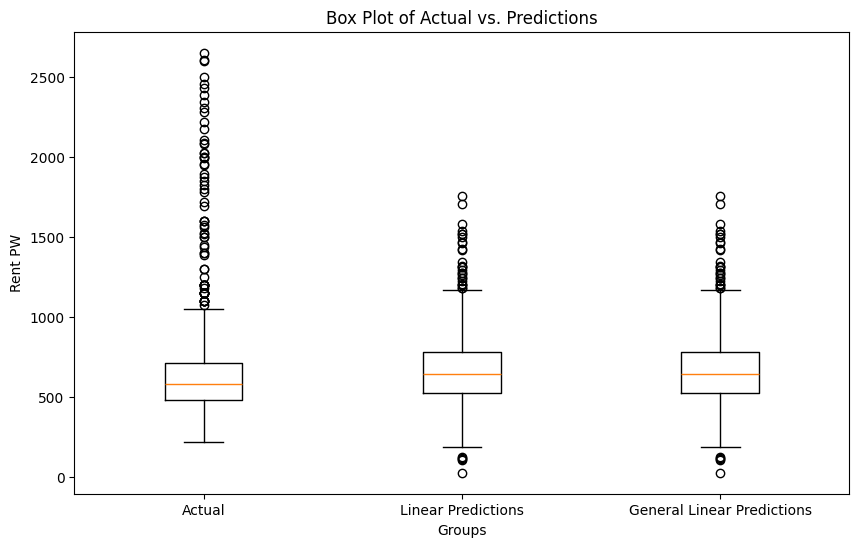

                 Generalized Linear Model Regression Results                  
Dep. Variable:          cost_per_week   No. Observations:                 3148
Model:                            GLM   Df Residuals:                     2956
Model Family:                Gaussian   Df Model:                          191
Link Function:               Identity   Scale:                          78066.
Method:                          IRLS   Log-Likelihood:                -22099.
Date:                Mon, 07 Oct 2024   Deviance:                   2.3076e+08
Time:                        19:19:26   Pearson chi2:                 2.31e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4648
Covariance Type:            nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 2: Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


# Step 3: Predict on the test data
linear_pred = linear_model.predict(X_test)

# Define scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(linear_model, X_train, y_train, scoring=scoring, cv=5)

# Step 5: Calculate the Mean Squared Error (MSE) and other metrics
linear_rmse = np.sqrt(cv_results['test_neg_mean_squared_error']).mean()
linear_mae = cv_results['test_neg_mean_absolute_error'].mean()
linear_r2 = cv_results['test_r2'].mean()

print("-----------------------------------------------------------------")
print("Linear Regression RMSE:", linear_rmse)
print("Linear Regression MAE:", linear_mae)
print("Linear Regression R^2:", linear_r2)
print("-----------------------------------------------------------------")

# Step 5: Generalized Linear Model (GLM)
# Add a constant to the model for intercept
# Step 2: Convert Boolean columns to integers (0 and 1)
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include=['bool']).columns})

X_train_glm = sm.add_constant(X_train)
X_test_glm = sm.add_constant(X_test)

X_train_glm = X_train_glm.apply(pd.to_numeric, errors='coerce')
X_test_glm = X_test_glm.apply(pd.to_numeric, errors='coerce')
y_train = y_train.apply(pd.to_numeric, errors='coerce')
y_test = pd.DataFrame(y_test)
y_test = y_test.apply(pd.to_numeric, errors='coerce')

glm_model = sm.GLM(y_train, X_train_glm, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Step 6: Predict on the test data using GLM
glm_pred = glm_results.predict(X_test_glm)

# Evaluate GLM
glm_rmse = np.sqrt(mean_squared_error(y_test, glm_pred))
glm_mae = mean_absolute_error(y_test, glm_pred)
glm_r2 = r2_score(y_test, glm_pred)

print("-----------------------------------------------------------------")
print("Generalized Linear Model RMSE:", glm_rmse)
print("Generalized Linear Model MAE:", glm_mae)
print("Generalized Linear Model R^2:", glm_r2)
print("-----------------------------------------------------------------")

# Create a figure for comparison
plt.figure(figsize=(10, 6))
y_test = y_test[0].to_numpy()
# Create box plots
plt.boxplot([y_test, linear_pred, glm_pred], labels=['Actual', 'Linear Predictions', 'General Linear Predictions'])

# Add title and labels
plt.title('Box Plot of Actual vs. Predictions')
plt.xlabel('Groups')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

# Print GLM summary
print(glm_results.summary())

# Extract the coefficients from the summary
coefficients = glm_results.params

# Get the top 10 highest coefficients
top_30_coefficients = coefficients.nlargest(30)

# Display the top 10 coefficients
print("Top 30 Coefficients")
print(top_30_coefficients)

/tmp/ipykernel_21408/391673953.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, rf_predictions, gb_pred, glm_pred], labels=['Actual', 'Random Forest Regression',


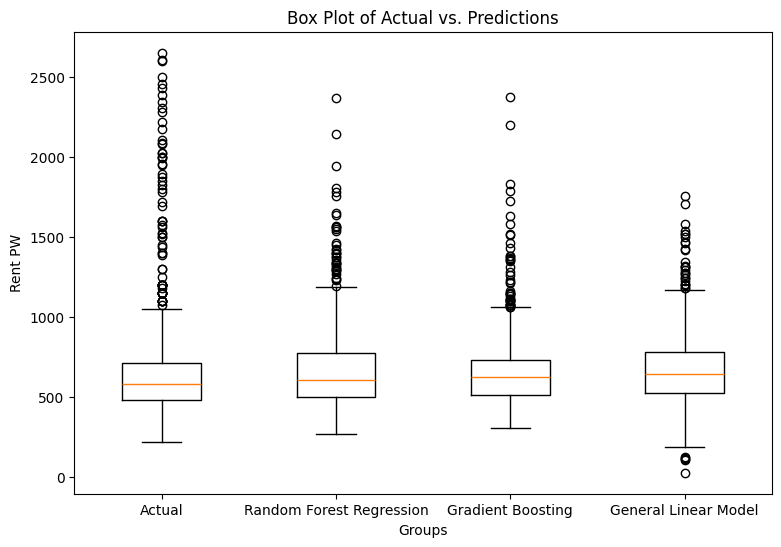

In [25]:
# Create a figure for comparison
plt.figure(figsize=(9, 6))

# Create box plots
plt.boxplot([y_test, rf_predictions, gb_pred, glm_pred], labels=['Actual', 'Random Forest Regression',
                                                                 'Gradient Boosting', 'General Linear Model'])

# Add title and labels
plt.title('Box Plot of Actual vs. Predictions')
plt.xlabel('Groups')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

In [23]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Feature Selection


In [18]:
from sklearn.feature_selection import SelectKBest, f_regression

X = finished_numerical

# Select the top 10 features
y = np.array(y).astype(float)
selector = SelectKBest(score_func=f_regression, k=30)
X_new = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: Index(['a20_assault_and_related_offences',
       'a80_dangerous_and_negligent_acts_endangering_people',
       'other_crimes_against_the_person', 'b10_arson', 'b20_property_damage',
       'd10_weapons_and_explosives_offences', 'e10_justice_procedures',
       'e20_breaches_of_orders', 'total_crimes',
       'avg_school_percentage_applying_to_victorian_uni',
       'zoned_school_median_study_score',
       'zoned_school_study_score_over_40_percent',
       'zoned_school_percentage_applying_to_victorian_uni',
       'crow_distance_to_cbd', 'distance_to_cbd', 'duration_to_cbd',
       'urban_percentage', 'developed_percentage', 'nature_percentage',
       'mean_economic: top 5% suburb', 'mean_economic: top 1% suburb',
       'mean_economic: gini coefficient',
       'mean_birth: united states of america', 'mean_housing: median',
       'mean_housing: avg 2 years', 'economic: median income',
       'economic: gini coefficient', 'economic: top 1% suburb',
       'econom

/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


In [19]:
selected_features_list = selected_features.tolist()

In [20]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE

model = LassoCV()
rfe = RFE(model, n_features_to_select=30)  # Change the number as needed
fit = rfe.fit(X, y)

selected_features_rfe = X.columns[fit.support_]
print("Selected Features using RFE:", selected_features_rfe)


Selected Features using RFE: Index(['total_area', 'birth: wales', 'birth: korea republic of south',
       'ages: 65-74', 'birth: bangladesh', 'birth: iran',
       'studying: tertiary total', 'birth: papua new guinea',
       'studying: tertiary FT 25+', 'studying: primary catholic',
       'studying: secondary total', 'birth: turkey', 'birth: zimbabwe',
       'relationships: defacto', 'birth: india', 'birth: france',
       'birth: new zealand', 'birth: born elsewhere',
       'relationships: other related individual',
       'birth: united states of america', 'ages: 75-84', 'birth: lebanon',
       'birth: bosnia and herzegovina', 'birth: ireland', 'birth: cambodia',
       'relationships: lone parents', 'birth: australia',
       'birth: hong kong sar of china', 'population: growth', 'birth: brazil'],
      dtype='object')


In [21]:
selected_features_rfe_list = selected_features_rfe.tolist()

In [22]:
final_features = list(set(selected_features_list + selected_features_rfe_list))

In [23]:
len(final_features)

59

In [24]:
finished_numerical = finished_df_full[final_features]
finished_categorical = finished_df_full[["type", "suburb", "rate_type"]]

finished_important = finished_df_full[["bedrooms", "bathrooms", "car_parks", "postcode"]]

finished_one_hot = pd.get_dummies(finished_categorical, 
                                  columns=['type', 'suburb', "rate_type"], 
                                  drop_first=True)

scaler = StandardScaler()
finished_scaled = scaler.fit_transform(finished_numerical)
finished_scaled_df = pd.DataFrame(finished_scaled, columns=finished_numerical.columns)
finished_scaled_important = scaler.fit_transform(finished_important)
finished_scaled_important = pd.DataFrame(finished_scaled_important, columns=finished_important.columns)

X = pd.concat([finished_important.reset_index(drop=True), finished_numerical, finished_one_hot.reset_index(drop=True)], axis = 1)
y = finished_df_full['cost_per_week']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+08, tolerance: 3.839e+04
  model = cd_fast.enet_coordinate_descent(
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.682e+07, tolerance: 3.100e+04
  model = cd_fast.enet_coordinate_descent(
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

-----------------------------------------------------------------
Lasso Regression RMSE: 291.65747194217704
Lasso Regression MAE: 155.20753787005003
Lasso Regression R^2: 0.3000251003681117
-----------------------------------------------------------------


/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.621e+07, tolerance: 3.178e+04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_27883/1696141502.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, lasso_pred], labels=['Actual', 'Lasso Predictions'])


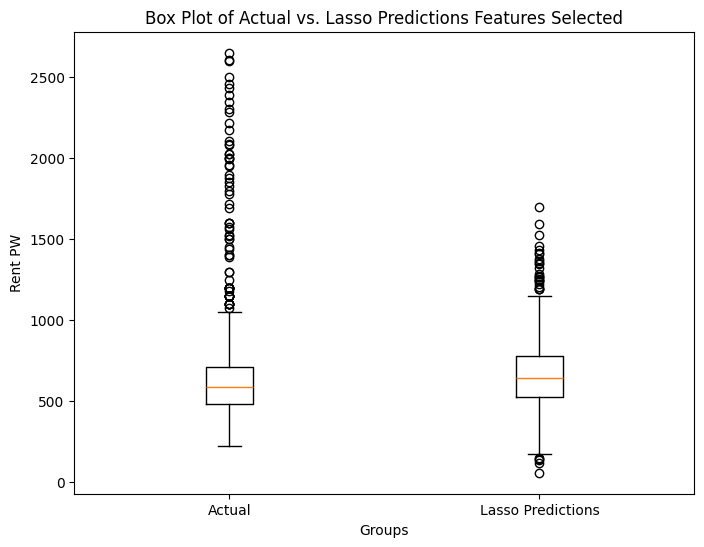

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Step 2: Initialize the Lasso regression model
lasso = Lasso(alpha=0.1)  # You can adjust the alpha (regularization strength) as needed

# Step 3: Fit the Lasso regression model
lasso.fit(X_train, y_train)

# Step 4: Predict on the test data
lasso_pred = lasso.predict(X_test)

# Define scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(lasso, X_train, y_train, scoring=scoring, cv=5)

# Step 5: Calculate the Mean Squared Error (MSE) and other metrics
lasso_rmse = np.sqrt(cv_results['test_neg_mean_squared_error']).mean()
lasso_mae = cv_results['test_neg_mean_absolute_error'].mean()
lasso_r2 = cv_results['test_r2'].mean()

# Print results
print("-----------------------------------------------------------------")
print("Lasso Regression RMSE:", lasso_rmse)
print("Lasso Regression MAE:", lasso_mae)
print("Lasso Regression R^2:", lasso_r2)
print("-----------------------------------------------------------------")

# Convert y_test and lasso_pred to float arrays
y_test = np.array(y_test).astype(float)
lasso_pred = np.array(lasso_pred).astype(float)

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, lasso_pred], labels=['Actual', 'Lasso Predictions'])

# Add title and labels
plt.title('Box Plot of Actual vs. Lasso Predictions Features Selected')
plt.xlabel('Groups')
plt.ylabel('Rent PW')

# Show the plot
plt.show()


-----------------------------------------------------------------
Gradient Boosting RMSE: 276.0141138269188
Gradient Boosting MAE: 134.07540300306874
Gradient Boosting r^2: 0.37350353184467455
-----------------------------------------------------------------

Top 10 Most Significant Features:
                                      Feature  Importance
0                                    bedrooms    0.239056
1                                   bathrooms    0.193246
37                    economic: median income    0.077673
58   zoned_school_study_score_over_40_percent    0.071588
2                                   car_parks    0.056804
41            mean_economic: gini coefficient    0.046833
42                            duration_to_cbd    0.024050
19                            distance_to_cbd    0.023729
48                       crow_distance_to_cbd    0.019973
114                       suburb_Coburg North    0.016840



/tmp/ipykernel_27883/925083966.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, gb_pred], labels=['Actual', 'Gradient Boosting Predictions'])


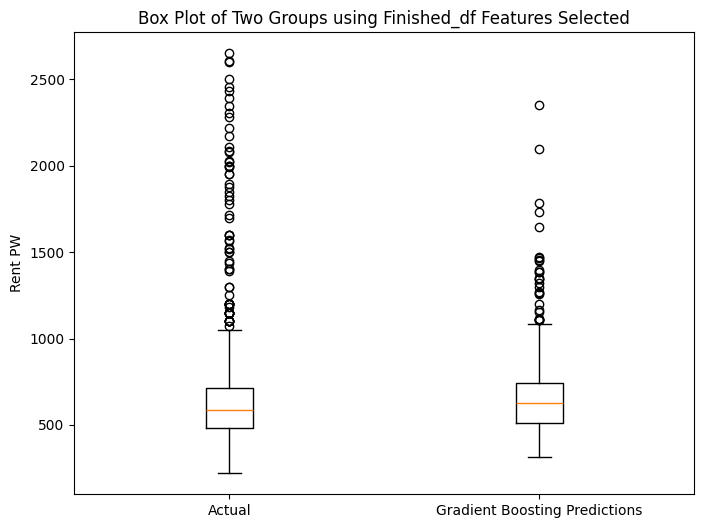

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# Define scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(gb_model, X_train, y_train, scoring=scoring, cv=5)

# Step 5: Calculate the Mean Squared Error (MSE) and other metrics
gb_rmse = np.sqrt(cv_results['test_neg_mean_squared_error']).mean()
gb_mae = cv_results['test_neg_mean_absolute_error'].mean()
gb_r2 = cv_results['test_r2'].mean()

print("-----------------------------------------------------------------")
print("Gradient Boosting RMSE:", gb_rmse)
print("Gradient Boosting MAE:", gb_mae)
print("Gradient Boosting r^2:", gb_r2)
print("-----------------------------------------------------------------")

feature_importances = gb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("")
y_test = np.array(y_test).astype(float)
lasso_pred = np.array(lasso_pred).astype(float)

# Top 5 most significant features
print("Top 10 Most Significant Features:")
print(importance_df.head(10))
print("")

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, gb_pred], labels=['Actual', 'Gradient Boosting Predictions'])

# Add title and labels
plt.title('Box Plot of Two Groups using Finished_df Features Selected')
plt.xlabel('')
plt.ylabel('Rent PW')

# Show the plot
plt.show()

-----------------------------------------------------------------
Random Forest Regression RMSE: 276.0141138269188
Random Forest Regression MAE: 134.07540300306874
Random Forest Regression r^2: 0.37350353184467455
-----------------------------------------------------------------

Top 10 Most Significant Features:
                                     Feature  Importance
0                                   bedrooms    0.167847
1                                  bathrooms    0.149172
2                                  car_parks    0.106934
37                   economic: median income    0.052884
42                           duration_to_cbd    0.025535
65                                type_House    0.024199
33                economic: gini coefficient    0.021067
63              type_Apartment / Unit / Flat    0.019803
58  zoned_school_study_score_over_40_percent    0.018958
41           mean_economic: gini coefficient    0.017678



/tmp/ipykernel_27883/3010206452.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, rf_predictions], labels=['Actual', 'RFR Predictions'])


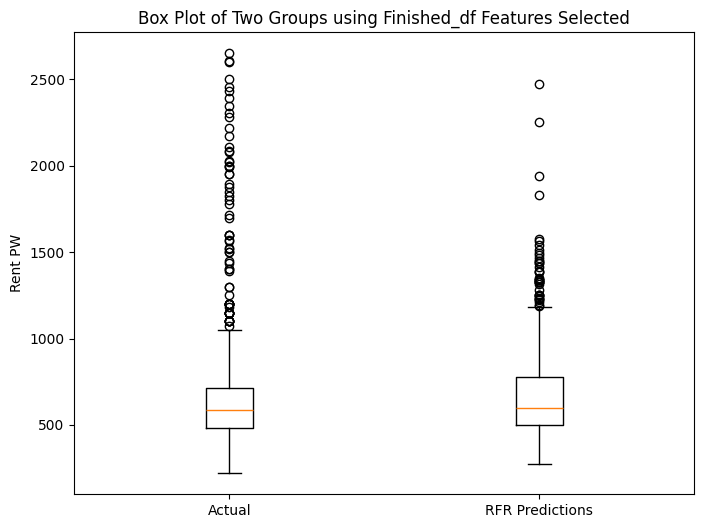

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Fit Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Define scoring metrics
scoring = {
    'neg_mean_squared_error': make_scorer(mean_squared_error),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Perform cross-validation
cv_results = cross_validate(gb_model, X_train, y_train, scoring=scoring, cv=5)

# Step 5: Calculate the Mean Squared Error (MSE) and other metrics
rf_rmse = np.sqrt(cv_results['test_neg_mean_squared_error']).mean()
rf_mae = cv_results['test_neg_mean_absolute_error'].mean()
rf_r2 = cv_results['test_r2'].mean()

# Predict on test data
rf_predictions = rf_model.predict(X_test)
print("-----------------------------------------------------------------")
print("Random Forest Regression RMSE:", rf_rmse)
print("Random Forest Regression MAE:", rf_mae)
print("Random Forest Regression r^2:", rf_r2)
print("-----------------------------------------------------------------")

# Feature importance for Random Forest
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("")
y_test = np.array(y_test).astype(float)
lasso_pred = np.array(lasso_pred).astype(float)

# Top 5 most significant features
print("Top 10 Most Significant Features:")
print(importance_df.head(10))
print("")

# Create a figure
plt.figure(figsize=(8, 6))

# Create box plots
plt.boxplot([y_test, rf_predictions], labels=['Actual', 'RFR Predictions'])

# Add title and labels
plt.title('Box Plot of Two Groups using Finished_df Features Selected')
plt.xlabel('')
plt.ylabel('Rent PW')

# Show the plot
plt.show()